# Reproduce DL
## Automated Pavement Crack Segmentation

We start by setting up the actual Architecture. This means making sure all weights are properly initialized and all layers are connected. 

We make use of PyTorch for the implementation.

Multiple parts come together (A U-based ResNet);
- We recreate ResNet34 and remove the last two layers
- We made sure that a ResNet-block is either 4 or 6 layers depending on if stride is not 1 (which in our case always happens when the in_channels are not equal to out_channels)
- We use transfer learning such that the ResNet34 parameters are initialized as if trained on ImageNet
- We create Squeeze and Excitation blocks that are applied per Channel (cSE) and per Spatial (sSE) (image)
- These two blocks are combined (scSE) and then the maximum of this is taken
- Each convolutional layer its parameters are initialized via "He Kaiming" method.

In [ ]:
from architecture import main
from torchsummary import summary
import torch

network = main.Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = network.to(device)

# print(network)
summary(model, input_size=(3, 320, 480))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 160, 240]           9,408
       BatchNorm2d-2         [-1, 64, 160, 240]             128
              ReLU-3         [-1, 64, 160, 240]               0
            Conv2d-4        [-1, 128, 160, 240]           8,320
         MaxPool2d-5          [-1, 64, 80, 120]               0
            Conv2d-6          [-1, 64, 80, 120]          36,864
       BatchNorm2d-7          [-1, 64, 80, 120]             128
              ReLU-8          [-1, 64, 80, 120]               0
            Conv2d-9          [-1, 64, 80, 120]          36,864
      BatchNorm2d-10          [-1, 64, 80, 120]             128
             ReLU-11          [-1, 64, 80, 120]               0
         ResBlock-12          [-1, 64, 80, 120]               0
           Conv2d-13          [-1, 64, 80, 120]          36,864
      BatchNorm2d-14          [-1, 64, 

The current dataset is size:  118 
The current split is train/test:  71 / 47


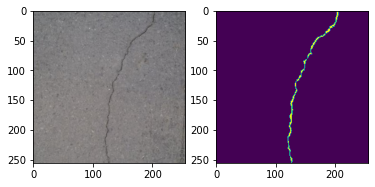

In [2]:
import os
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import matplotlib.pyplot as plt
from datasets.CFD.CFDdata import CFD

current_path = os.path.abspath(os.getcwd())

resize_image = (256, 384)
crop_image = 256

shared_transforms = [
    transforms.RandomCrop(crop_image),
    transforms.Pad(200, padding_mode='reflect'),
    transforms.RandomRotation((0,360)),
    transforms.CenterCrop(crop_image),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
]

tf_compos = transforms.Compose([
    transforms.Resize(resize_image, interpolation=InterpolationMode.BILINEAR),
    *shared_transforms, 
    transforms.ColorJitter(brightness=0.05, contrast=0.05), 
    transforms.ToTensor()
    ])

tf_compos_gt = transforms.Compose([
    transforms.Resize(resize_image, interpolation=InterpolationMode.NEAREST),
    *shared_transforms, 
    transforms.ToTensor()
    ])

dataset = CFD(current_path + "/datasets/CFD/cfd_image/", tf_compos, current_path + "/datasets/CFD/seg_gt/", tf_compos_gt)


train_data, test_data = random_split(dataset, [71, 47])
train_loader = DataLoader(train_data, batch_size=10)
test_loader = DataLoader(test_data, batch_size=47)


## Dataloader debugging
print("The current dataset is size: ", len(dataset), 
"\nThe current split is train/test: ", len(train_loader.dataset), "/", len(test_loader.dataset))
# ----------------------------
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import torchvision

import traceback
try:
    image, label = dataset[6]
except Exception:
    traceback.print_exc()

image = transforms.ToPILImage()(image)
label = transforms.ToPILImage()(label)

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(image)
axarr[1].imshow(label)
# # ----------------------------

In [ ]:
def evaluate_accuracy(data_loader, network, device=torch.device("cpu")):
    """Evaluate accuracy of a model on the given data set."""
    network.eval()  #make sure network is in evaluation mode

    #init
    acc_sum = torch.tensor([0], dtype=torch.float32, device=device)
    n = 0

    for X, y in data_loader:
        # Copy the data to device.
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            y = y.long()
            acc_sum += torch.sum((torch.argmax(network(X), dim=1) == y))
            n += y.shape[0] #increases with the number of samples in the batch
    return acc_sum.item()/n

In [6]:
# Set up simple loop on CPU, one epoch
from architecture import main
from loss.loss import batch_dice_loss
from utils.layers import layer_split
from utils.retrieve_device import try_gpu
import torch
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm


# training parameters
lr = 1e-2

epochs = 1

# Define list to store losses and performances of each interation
train_losses = []
train_accs = []
test_accs = []

# Try using cpu
device = torch.device('cpu')

#Initialize network
network = main.Net()

#Initiliaze loss function
criterion = batch_dice_loss

optimizer = torch.optim.AdamW(network.parameters(), lr=lr, betas=(0.9, 0.999))


for epoch in tqdm(range(epochs)):

     # Network in training mode and to device
     network.train()
     network.to(device)

     # Training loop
     for i, (x_batch, y_batch) in enumerate(train_loader):

          # Set to same device
          x_batch, y_batch = x_batch.to(device), y_batch.to(device)

          # Set the gradients to zero
          optimizer.zero_grad()

          # Perform forward pass
          y_pred = network(x_batch)
          # Sigmoid -> [0, 1], reflect probabilities
          y_pred = torch.sigmoid(y_pred)
          print(f"y_pred: {y_pred}")
          print(f"x_batch: {torch.unique(x_batch)}")


          # Compute the loss
          loss = criterion(y_pred, y_batch)
          train_losses.append(loss)

          # Backward computation and update
          loss.backward()
          optimizer.step()

     # Compute train and test error
     train_acc = 100*evaluate_accuracy(train_loader, network.to(device))
     test_acc = 100*evaluate_accuracy(test_loader, network.to(device))

     # Development of performance
     train_accs.append(train_acc)
     test_accs.append(test_acc)

     # Save model
     d = network.state_dict()
     torch.save(d, "model_parameters_cpu.pt")   

     # Print performance
     print('Epoch: {:.0f}'.format(epoch+1))
     print('Accuracy of train set: {:.00f}%'.format(train_acc))
     print('Accuracy of test set: {:.00f}%'.format(test_acc))
     print('')

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Set up simple loop on GPU, one epoch

from architecture import main
from loss.loss import batch_dice_loss
from utils.layers import layer_split
from utils.retrieve_device import try_gpu
import torch
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm


# training parameters
lr = 1e-3

epochs = 1

# Define list to store losses and performances of each interation
train_losses = []
train_accs = []
test_accs = []

# Try using gpu
device = torch.device('cuda:0')

#Initialize network
network = main.Net()

#Initiliaze loss function
criterion = batch_dice_loss

optimizer = torch.optim.AdamW(network.parameters(), lr=lr, betas=(0.9, 0.999))


for epoch in tqdm(range(epochs)):

    # Network in training mode and to device
    network.train()
    network.to(device)

    # Training loop
    for i, (x_batch, y_batch) in enumerate(train_loader):

        # Set to same device
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Set the gradients to zero
        optimizer.zero_grad()

        # Perform forward pass
        y_pred = network(x_batch)

        # Compute the loss
        loss = criterion(y_pred, y_batch)
        train_losses.append(loss)

        # Backward computation and update
        loss.backward()
        optimizer.step()
    
    # Compute train and test error
    train_acc = 100*evaluate_accuracy(train_loader, network.to("cpu"))
    test_acc = 100*evaluate_accuracy(test_loader, network.to("cpu"))
    
    # Development of performance
    train_accs.append(train_acc)
    test_accs.append(test_acc)   

    # Print performance
    print('Epoch: {:.0f}'.format(epoch+1))
    print('Accuracy of train set: {:.00f}%'.format(train_acc))
    print('Accuracy of test set: {:.00f}%'.format(test_acc))
    print('')

# Save model
torch.save(network.state_dict(), "model_parameters_gpu.pt")

In [ ]:
# Elaborate loop of multiple Epoch
from architecture import main
from loss.loss import batch_dice_loss
from utils.layers import layer_split
from utils.retrieve_device import try_gpu
import torch


def evaluate_accuracy(data_loader, network, device=torch.device("cpu")):
    """Evaluate accuracy of a model on the given data set."""
    network.eval()  #make sure network is in evaluation mode
    device = try_gpu()

    #init
    acc_sum = torch.tensor([0], dtype=torch.float32, device=device)
    n = 0

    for X, y in data_loader:
        # Copy the data to device.
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            y = y.long()
            acc_sum += torch.sum((torch.argmax(network(X), dim=1) == y))
            n += y.shape[0] #increases with the number of samples in the batch
    return acc_sum.item()/n

# training parameters
lr = 1e-2

# Always needs to be a factor of 3
# Phase 1 = 1/3 time, Phase 2 = 2/3 time
EPOCHS = 12
epochs_1 = ( EPOCHS // 3 )
epochs_2 = ( EPOCHS // 3 ) * 2

# Define list to store losses and performances of each interation
train_losses = []
train_accs = []
test_accs = []

# Try using gpu instead of cpu
device = try_gpu()

#Initialize network
network = main.Net()

#Initiliaze loss function
criterion = batch_dice_loss

# Split layers into three, for seperate optimization
layer_1, layer_2, layer_3 = layer_split(network)

optimizer = torch.optim.AdamW([
    {'params': layer_1, 'lr': 0},
    {'params': layer_2, 'lr': lr/3},
    {'params': layer_3, 'lr': lr}], betas=(0.9, 0.999))

for epoch in range(epochs_1):

    # Network in training mode and to device
    network.train()
    network.to(device)

    # Training loop
    for i, (x_batch, y_batch) in enumerate(train_loader):

         # Set to same device
         x_batch, y_batch = x_batch.to(device), y_batch.to(device)

         # Set the gradients to zero
         optimizer.zero_grad()

         # Perform forward pass
         y_pred = network(x_batch)

         # Compute the loss
         loss = criterion(y_pred, y_batch)
         train_losses.append(loss)

         # Backward computation and update
         loss.backward()
         optimizer.step()
    
    # Compute train and test error
    train_acc = 100*evaluate_accuracy(train_loader, network.detach().cpu())
    test_acc = 100*evaluate_accuracy(test_loader, network.detach().cpu())
    
    # Development of performance
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    # Print performance
    print('Epoch: {:.0f}'.format(epoch+1))
    print('Accuracy of train set: {:.00f}%'.format(train_acc))
    print('Accuracy of test set: {:.00f}%'.format(test_acc))
    print('')

optimizer = torch.optim.AdamW([
    {'params': layer_1, 'lr': lr/9},
    {'params': layer_2, 'lr': lr/3},
    {'params': layer_3, 'lr': lr}], betas=(0.9, 0.999))

for epoch in range(epochs_2):

    # Network in training mode and to device
    network.train()
    network.to(device)

    # Training loop
    for i, (x_batch, y_batch) in enumerate(train_loader):

         # Set to same device
         x_batch, y_batch = x_batch.to(device), y_batch.to(device)

         # Set the gradients to zero
         optimizer.zero_grad()

         # Perform forward pass
         y_pred = network(x_batch)

         # Compute the loss
         loss = criterion(y_pred, y_batch)
         train_losses.append(loss)

         # Backward computation and update
         loss.backward()
         optimizer.step()
    
    # Compute train and test error
    train_acc = 100*evaluate_accuracy(train_loader, network.detach().cpu())
    test_acc = 100*evaluate_accuracy(test_loader, network.detach().cpu())
    
    # Development of performance
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    # Save model
    d = network.state_dict()
    torch.save(d, "model_parameters.pt")   

    # Print performance
    print('Epoch: {:.0f}'.format(epoch+1))
    print('Accuracy of train set: {:.00f}%'.format(train_acc))
    print('Accuracy of test set: {:.00f}%'.format(test_acc))
    print('')

KeyboardInterrupt: 

In [ ]:
# from torchviz import make_dot

# x = torch.randn(1,3, 320, 480)
# y = net(x) 

# make_dot(y).view()

In [ ]:
import torch




<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=411d58e9-cb4b-4924-bef0-2f383eff0187' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>